# Import and Function Definition

In [ ]:
from keras.models import load_model
from keras.preprocessing.image import img_to_array
from matplotlib.pyplot import imshow,axis
import matplotlib.pyplot as plt

import cv2
from os.path import dirname,basename,join
import imutils
import numpy as np

In [2]:
plt.rcParams["figure.figsize"] = [20, 16]


IMG_WIDTH=600

In [3]:
def imshow2(img):
    img2=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axis("off")
    imshow(img2)
def imshow2(img):
    img2=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axis("off")
    imshow(img2)

def imgToFrame(img):
    return imutils.resize(img,width=IMG_WIDTH)

def getEmotion(img):
    frame=imgToFrame(img)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    faces = face_detection.detectMultiScale(gray,
                                            scaleFactor=1.1,
                                            minNeighbors=5,
                                            minSize=(30,30),
                                            flags=cv2.FONT_HERSHEY_COMPLEX_SMALL
                                           )
    if len(faces) > 0:
        faces = sorted(faces, 
                       reverse=True, 
                       key=lambda x: (x[2] - x[0]) * (x[3] - x[1])
                      )[0]
        (fX, fY, fW, fH) = faces
                    # Extract the ROI of the face from the grayscale image, resize it to a fixed 28x28 pixels, and then prepare
            # the ROI for classification via the CNN
        roi = gray[fY:fY + fH, fX:fX + fW]
        roi = cv2.resize(roi, (64, 64))
        roi = roi.astype("float") / 255.0
        roi = img_to_array(roi)
        roi = np.expand_dims(roi, axis=0)

        preds = emotion_classifier.predict(roi)[0]
    else:
         print('-----------no face------------------')
         return (preds,frame,faces)

    return (preds,frame,faces)

In [4]:
def getEmotionImg(preds,frame,faces):
    canvas = np.zeros((250, IMG_WIDTH, 3), dtype="uint8")
    frameClone = frame.copy()
    predString=''
    (fX, fY, fW, fH) = faces
    label = EMOTIONS[preds.argmax()]
    for (i, (emotion, prob)) in enumerate(zip(EMOTIONS, preds)):

        # construct the label text
        text="{}: {:.2f}% \n".format(emotion, prob * 100)
        predString+=text 
        w = int(prob * 300)
        # 그래프 그리는 부분
        cv2.rectangle(canvas, (7, (i * 35) + 5),(w, (i * 35) + 35), (0, 0, 255), -1)
        cv2.putText(canvas, text[:-1], (10, (i * 35) + 23),cv2.FONT_HERSHEY_SIMPLEX, 0.7,(255, 255, 255), 2)

        # Bounding Box와 레이블 그리는 부분
        cv2.putText(frameClone, label, (fX, fY - 10),cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
        cv2.rectangle(frameClone, (fX, fY), (fX + fW, fY + fH), (0, 0, 255), 2)
    return [predString, frameClone , canvas ]

# Model 준비

In [5]:
# parameters for loading data and images
detection_model_path = 'haarcascade_files/haarcascade_frontalface_default.xml'
emotion_model_path = 'models/_mini_XCEPTION.102-0.66.hdf5'

# hyper-parameters for bounding boxes shape
# loading models
face_detection = cv2.CascadeClassifier(detection_model_path)
emotion_classifier = load_model(emotion_model_path, compile=False)
EMOTIONS = ["angry" ,"disgust","scared", "happy", "sad", "surprised", "neutral"]

# Implementation

## Image Implementation

In [6]:
# img = cv2.imread('/prj/nowage/_git/kcse/Emotion-recognition/data/sh01.jpg')
img = cv2.imread('/prj/nowage/_git/kcse/Emotion-recognition/data/nowage.jpg')
# img = cv2.imread('/prj/nowage/_git/kcse/Emotion-recognition/data/h1.jpg')

In [7]:
getEmotion(img)[0]

array([0.18392827, 0.02128678, 0.5292358 , 0.00221991, 0.17279375,
       0.03946511, 0.05107043], dtype=float32)

In [8]:
eImg=getEmotionImg(*getEmotion(img) )
print(eImg[0])

angry: 18.39% 
disgust: 2.13% 
scared: 52.92% 
happy: 0.22% 
sad: 17.28% 
surprised: 3.95% 
neutral: 5.11% 



In [9]:
cv2.vconcat(eImg[1:3]).shape

(663, 600, 3)

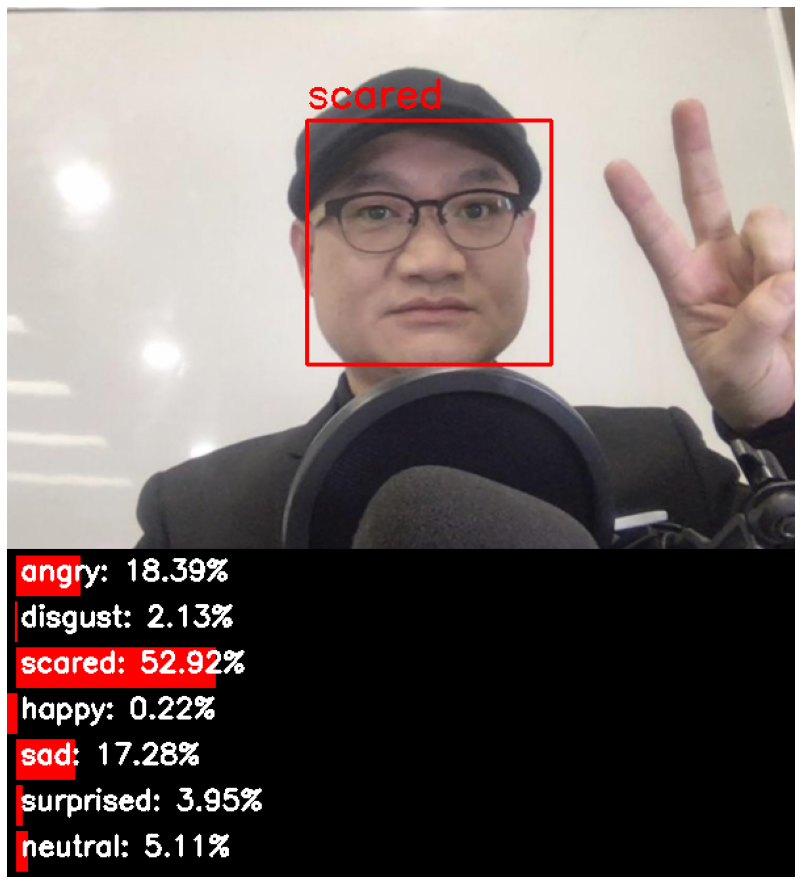

In [10]:
imshow2(cv2.vconcat(eImg[1:3]) )

## Movie Implementation

In [ ]:
 
def video2emotion(videofilename, img_save_path='',csv_save_path=''):
    vidcap = cv2.VideoCapture(videofilename)
    count = 0
    emotions=[]
    while True:
      success,image = vidcap.read()
      if not success:
        if not csv_save_path == '':
            print(join(dirname(csv_save_path), basename(videofilename)+'.csv'))
            np.savetxt(
                join(dirname(csv_save_path), basename(videofilename)+'.csv'),
                np.array(emotions),
                delimiter=',',
                fmt="%0.4f"
            )    
            return emotions
      if not img_save_path == '':
        try:
          fname = "{}.jpg".format("{0:05d}".format(count))
          eImg=getEmotionImg(*getEmotion(image) )
          image2=cv2.vconcat(eImg[1:3])
          cv2.imwrite(img_save_path + fname, image2) # save frame as JPEG file
        except:
          pass ##             print('csv save err : video2emotion')        
        finally:
          pass
      if not csv_save_path == '':
        try:  
          emotions.append(getEmotion(image)[0])
        except:
          pass
        finally:
          pass
            
      count += 1
#         print("{} images are extracted in {}.". format(count, img_save_path +fname))
#       if count>10:
#         if not csv_save_path == '':
#             print(join(dirname(csv_save_path), basename(videofilename)+'.csv'))
#             print(np.array(emotions))
#             np.savetxt(
#                 join(dirname(csv_save_path), basename(videofilename)+'.csv'),
#                 np.array(emotions),
#                 delimiter=',',
#                 fmt="%0.4f"
#             )
#             break;
# x=video2emotion('/prj/nowage/_git/kcse/data/test.mp4','/prj/nowage/_git/kcse/Emotion-recognition/test/')
# x=video2emotion('/prj/nowage/_git/kcse/data/test.mp4',csv_save_path='/prj/nowage/GoogleDrive_finfra/_FinfraWork/KCSE/csv/')

# x=video2emotion('/prj/nowage/_git/kcse/data/mp4/a2a2sh-bap-3_0.mp4',img_save_path='/prj/nowage/_git/kcse/Emotion-recognition/test/1.bap/')
# x=video2emotion('/prj/nowage/_git/kcse/data/mp4/b2je-5-1_0.mp4','/prj/nowage/_git/kcse/Emotion-recognition/test/2.juk/')
x=video2emotion('/prj/nowage/_git/kcse/data/mp4/c2je-12-2_0.mp4','/prj/nowage/_git/kcse/Emotion-recognition/test/3.mieum/')

In [147]:
# !rm /prj/nowage/GoogleDrive_finfra/_FinfraWork/KCSE/csv/test.mp4.csv


In [163]:
x=video2emotion('/prj/nowage/_git/kcse/data/mp4/c3sh-12-2.mp4',csv_save_path='/prj/nowage/GoogleDrive_finfra/_FinfraWork/KCSE/csv/')


/prj/nowage/GoogleDrive_finfra/_FinfraWork/KCSE/csv/c3sh-12-2.mp4.csv


In [199]:
# !rm /prj/nowage/GoogleDrive_finfra/_FinfraWork/KCSE/csv/*


^C


In [ ]:
videofilePath='/prj/nowage/_git/kcse/data/mp4'
csv_save_path='/prj/nowage/GoogleDrive_finfra/_FinfraWork/KCSE/csv/'
for f in os.listdir(videofilePath):
    ff=join(videofilePath,f)
    print(ff,csv_save_path)    
    x=video2emotion(ff,csv_save_path=csv_save_path)

    try:
        x=video2emotion(ff,csv_save_path=csv_save_path)
    except:
        print('err=',ff)
    finally:
        print(ff,csv_save_path)    

